# 1. Experimentos utilizando K-Means para Agrupamento

Neste notebook serão exploradas maneiras automatizadas de segmentar os clientes com base nos atributos escolhidos anteriormente. K-Means será o algoritmo escolhido com base na sua fácil interpretabilidade e por ser um algoritmo conhecido para tarefas de agrupamento.

## Cuidados ao utilizar mecanismos automáticos

Como qualquer problema na computação e talvez na vida, devemos saber quais ferramentas usar para cada problema e entender como as ferramentas funcionam para evitar resultados indesejados, ou pior, resultados desejados, mas incorretos.

No caso deste processo de segmentação, uma grande importância relacionada aos resultados se darão por parte de como os dados serão preprocessados.

Por conta disso, serão aplicadas técnicas de processamento e, com base nos resultados do modelo, serão definidas as segmentações finais para o uso na API desenvolvida.

### 1.1 Inicialização

In [1]:
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set_theme()
sns.set_style("whitegrid")

# Random State
RS=42
COLORS = {0: 'blue',
         1: 'green',
         2: 'red',
         3: 'brown'}

rfm = pd.read_csv('../data/processed/rfm.csv')
rfm.head()

,CustomerID,Recency,Frequency,Amount,Country
0,12346.0,326,0.0,0.00,United Kingdom
1,12347.0,40,182.0,4310.00,Iceland
2,12348.0,76,31.0,1797.24,Finland
3,12349.0,19,73.0,1757.55,Italy
4,12350.0,311,17.0,334.40,Norway


### 1.2 Geração AD-HOC de clusters

Primeiramente vamos explorar os resultados de uma segmentação realizada com K-Means utilizando Sklearn.

Para isso utilizaremos os atributos numéricos disponíveis na base gerada no notebook exploratório.

Neste exemplo, serão gerados apenas 4 grupos para realizar a segmentação de clientes. Espera-se que a segmentação seja feita de forma que seja fácil entender o motivo das diferenças entre os segmentos.

A quantidade de 4 grupos foi escolhida de forma AD-HOC a partir de alguns testes empíricos. Como dizem por aí: "hindsight é 20/20".

### Iniciando

Para começar, será explorada uma segmentação realizada sem modificações no dataset. Foram utilizados apenas os atributos numéricos visto que dados de localidade são uma forma de segmentar os clientes de forma separada.

A seguir são apresentados 2 gráficos para visualização da segmentação definida pelo K-Means.

A visualização 2D foi gerada a partir da aplicação do algoritmo de PCA, que realiza uma redução de dimensionalidade dos atributos mantendo apenas os atributos com informações mais relevantes.

In [2]:
# Vai ser usado algumas vezes para plotar
def plot2d(X, colors, title='Visualização 2D'):
    X_2d = sklearn.decomposition.PCA(2).fit_transform(X)
    x = X_2d[:, 0]
    y = X_2d[:, 1]
    plt.scatter(x, y, c=colors)
    plt.title("Visualização 2D")

def plot3d(x, y, z, colors, xlabel='Recência (maior é pior)', zlabel='Gastos (em milhares)', ylabel='Frequência', title='Dados Segmentados'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=x, ys=y, zs=z, c=colors)
    ax.set_xlabel(xlabel)
    ax.set_zlabel(zlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def run_kmeans(X, n_clusters=4):
    model = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=RS)
    prediction = model.fit(X)
    labels = prediction.labels_
    colors = [COLORS[x] for x in labels]
    return colors, labels

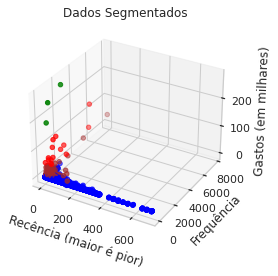

In [3]:
X = rfm[['Recency', 'Frequency', 'Amount']].copy()
colors, _ = run_kmeans(X)

x = rfm['Recency']
y = rfm['Frequency']
z = rfm['Amount'] / 1000

plot3d(x, y, z, colors)

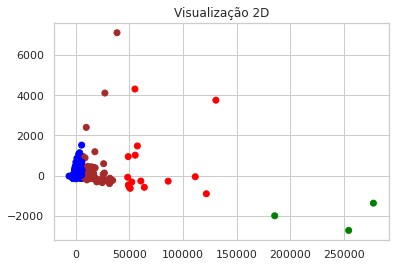

In [4]:
plot2d(X, colors)

Nota-se que no gráfico 3D, há uma segmentação onde o eixo de gastos parecer ter maior relevância. Apesar do maior espalhamento de exemplos no eixo de recência, o K-Means priorizou o eixo de gastos para segmentar os elementos.

Podemos ver esse comportamento no gráfico 2D, onde o PCA tendeu a deixar o eixo X como uma representação dos gastos e onde há visivelmente uma separação entre 4 grupos distintos de clientes.

A pergunta agora que vem é: Por qual motivo o K-Means resolveu cortar os clientes dessa forma? Aparentemente ele separou apenas entre clientes que gastam, de forma relativa, pouco, médio e muito.

O K-Means é um algoritmo baseado em distâncias e centróides. Isso quer dizer que a escala dos dadostem grande influência na decisão da separação dos grupos. Como o eixo dos gastos tem grandeza muito maior que os outros eixos, as distâncias entre os pontos presentes nesse eixo são maiores e por conta disso, a decisão de cálculo do centróide do grupo, que é baseado em distâncias, é fortemente enviesado por este eixo.

Como exemplo deste fenômeno, podemos notar a diferença na geração dos grupos ao mudar a escala dos outros atributos dos dados com visto abaixo:

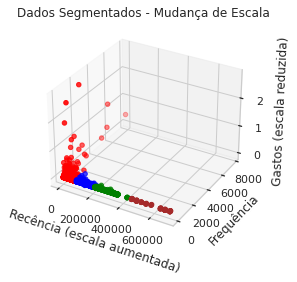

In [5]:
# Redução de escala
X = rfm[['Recency', 'Amount', 'Frequency']].copy()
X['Amount'] = X['Amount']  / 100000
X['Recency'] = X['Recency'] * 1000

# Obtendo coordenadas
x = X['Recency']
y = X['Frequency']
z = X['Amount']

# Definindo novo modelo
colors, _ = run_kmeans(X)

# Plot
plot3d(x, y, z, colors, title='Dados Segmentados - Mudança de Escala', xlabel='Recência (escala aumentada)', zlabel='Gastos (escala reduzida)')

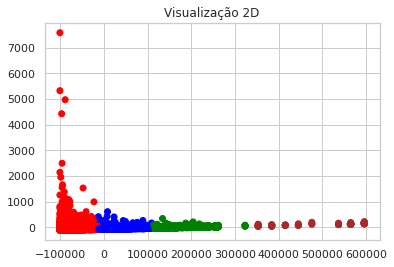

In [6]:
plot2d(X, colors, title='Visualização 2D - Redução de Escala')

Como forma de reduzir o efeito do viés causado pela diferença entre grandezas, exploraremos uma técnica de normalização abaixo.

## 1.3 Aplicando normalizações

Com o objetivo de reduzir o efeito da diferença de escala entre os atributos definidos, serão aplicadas técnicas de normalização que manterão os atributos com suas respectivas distribuições, mas normalizará a escala de todos os atributos, reduzindo a importância a priori encontrada no atributo anteriormente.

Logo abaixo, a normalização normal, também conhecida como [z-score](https://en.wikipedia.org/wiki/Standard_score) é utilizada.

A normalização é realizada a partir do seguinte cálculo:

$z = \frac{x - \bar{x}}{\sigma}$

Onde:

* $x$ é a amostra atual a ser normalizado
* $\bar{x}$ é a média de todas as amostras
* $\sigma$ é o desvio padrão das amostras

Esta normalização tem como objetivo centrar a média dos dados em 0 e manter o desvio padrão dos dados em 1. 

Cada atributo dos dados tem esse algoritmo aplicado individualmente, o que faz com que todos tenham média 0 e desvio padrão 1, normalizando a escala de todos os atributos numéricos e reduzindo o viés a priori dos dados.

### Observação:

* Será que faz sentido realmente transformar todos os dados para a mesma escala? Alguns atributos podem ser mais importantes que outros. De certa forma, os clientes que gastam mais com a empresa, no fim das contas, são clientes mais relevantes e que não devem ser perdidos. Isso mostra que existe hierarquia entre os atributos e a importância de cada um deles, entretanto, para esta análise, isso será ignorado.

In [7]:
X = rfm[['Recency', 'Amount', 'Frequency']]
ss = sklearn.preprocessing.StandardScaler()
X = pd.DataFrame(ss.fit_transform(X), columns=['Recency', 'Amount', 'Frequency'])
X.head()

,Recency,Amount,Frequency
0,1.975600,-0.231001,-0.397606
1,-0.535025,0.293432,0.415662
2,-0.219002,-0.012316,-0.259082
3,-0.719372,-0.017146,-0.071405
4,1.843924,-0.190312,-0.321642


Com os dados normalizados, podemos então reaplicar o K-Means e verificar os grupos gerados pelo algoritmo.

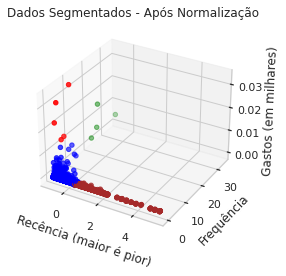

In [8]:
# Obtendo coordenadas
x = X['Recency']
y = X['Frequency']
z = X['Amount'] / 1000

# Definindo novo modelo
colors_out, labels_out = run_kmeans(X)

# Plot
plot3d(x, y, z, colors_out, title='Dados Segmentados - Após Normalização')

Na nova segmentação, podemos notar 4 grupos bem distintos de clientes, podemos interpretar estes como:

1. Azul - Clientes Comuns: Clientes que compraram recentemente, mas que no geral não são extremamente frequentes. Tem gastos relativamente baixos e compõem um grande número da base de dados.
2. Marrom - Ex-Clientes: Clientes que já compraram na empresa, mas que por alguma razão não voltaram a se relacionar com a empresa.
3. Verde - Clientes Recorrentes: Clientes que compram frequentemente na empresa. São clientes que provavelmente já se relacionam bem com a empresa por conta da recorrencia.
4. Vermelho - Clientes Premium: Clientes que, apesar de baixa frequência quando comparados aos clientes recorrentes, tem um gasto muito maior que a grande maioria dos clientes.

É perceptível nessa separação um balanço maior da importância existente entre cada atributo. Entretanto, nesse exemplo, também é notável a baixa quantidade de exemplos em clientes recorrentes (verdes) e premium (vermelhos), além de um grande agrupamento da maioria dos clientes no grupo de clientes comuns. É possível explorar mais este grupo de clientes ao removermos alguns clientes que são considerados outliers.

# 1.4 Removendo Outliers

A remoção de outliers consiste em remover instâncias da base de dados em que os valores são diferentes demais. Isso permite que o K-Means não seja enviesado por valores muito fora do padrão e permite geração de grupos com maior granularidade.

Para remover outliers, utilizaremos a [Regra do Intervalo Interquartil, IQR](https://en.wikipedia.org/wiki/Interquartile_range) que determina um intervalo entre 2 quartis dos dados e remove todos os elementos que excedem o 1.5 vezes o tamanho deste intervalo.

Para os quartis selecionados, serão utilizados os pontos nos precentis 1% e 99%.

In [9]:
def remove_outlier(df, column, quantiles=(0.01, 0.99)):
    q1 = df[column].quantile(quantiles[0])
    q2 = df[column].quantile(quantiles[1])
    iqr = q2 - q1
    df = df[(df[column] >= q1 - 1.5 * iqr) & (df[column] <= q2 + 1.5 * iqr)]
    return df

In [10]:
X = rfm[['Recency', 'Amount', 'Frequency']].copy()

X = remove_outlier(X, 'Recency')
X = remove_outlier(X, 'Amount')
X = remove_outlier(X, 'Frequency')

X = pd.DataFrame(ss.fit_transform(X), columns=['Recency', 'Amount', 'Frequency'], index=X.index)

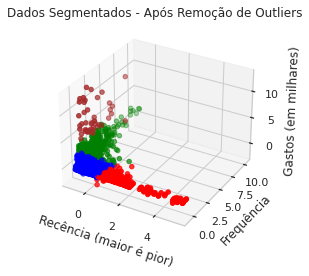

In [11]:
# Obtendo coordenadas
x = X['Recency']
y = X['Frequency']
z = X['Amount']

# Definindo novo modelo
colors, labels = run_kmeans(X)

# Plot
plot3d(x, y, z, colors, title='Dados Segmentados - Após Remoção de Outliers')

A partir da remoção de outliers, percebemos novos agrupamentos. Nota-se que os grupos continuam a ter características similares aos gerados antes da remoção de outliers, porém há uma maior granularidade e uma maior divisão no grupo que consideravamos clientes comuns.

Essa maior granularidade gerará uma segmentação mais significativa em relação aos dados existentes, sendo esta segmentação:

1. Azul - Clientes Comuns: Clientes que compraram recentemente, mas que no geral não são extremamente frequentes. Tem gastos relativamente baixos e compõem um grande número da base de dados.
2. Vermelho - Ex-Clientes: Clientes que já compraram na empresa, mas que por alguma razão não voltaram a se relacionar com a empresa.
3. Verde - Clientes Recorrentes: Clientes que compram frequentemente na empresa. São clientes que provavelmente já se relacionam bem com a empresa por conta da recorrencia.
4. Marrom - Clientes Premium: Clientes que, apesar de baixa frequência quando comparados aos clientes recorrentes, tem um gasto muito maior que a grande maioria dos clientes.

# 1.5 Combinando e armazenando segmentações

Com o objetivo de utilizar estas segmentações na API desenvolvida, serão determinados a qual grupo cada usuário pertence. Para isso serão combinadas as segmentações geradas pelos dois últimos modelos de agrupamento.

O objetivo de combinar as reprenseções é não perder as informações de segmentação do modelo mais geral, onde incluiu-se outliers.

Para realizar esta combinação, utilizarei os dados do modelo geral em todos os clientes que eram considerados outliers enquanto os clientes do dataset sem outliers serão segmentados pelos grupos do segundo modelo.

### Tabela de Labels e suas respectivas cores:
| Modelo com Outliers | Label
|---|---|
0 - Azul|Clientes Comuns|
3 - Marrom|Ex-Clientes
1 - Verde|Clientes Recorrentes
2 - Vermelho| Clientes Premium

In [12]:
labels = pd.Series(labels, index=X.index, dtype=int)

new_rfm = rfm.copy()

new_rfm['LabelOutliers'] = labels_out
new_rfm['Label'] = labels
new_rfm['Label'] = new_rfm['Label'].apply(lambda x: 3 if x == 2 else 2 if x == 3 else x)
new_rfm['Label'] = new_rfm['Label'].fillna(new_rfm['LabelOutliers']).astype(int)
new_rfm = new_rfm.drop('LabelOutliers', axis=1)

In [13]:
new_rfm.head()

,CustomerID,Recency,Frequency,Amount,Country,Label
0,12346.0,326,0.0,0.00,United Kingdom,3
1,12347.0,40,182.0,4310.00,Iceland,1
2,12348.0,76,31.0,1797.24,Finland,0
3,12349.0,19,73.0,1757.55,Italy,0
4,12350.0,311,17.0,334.40,Norway,3


## 1.6 Finalizando

Por fim, estes dados serão salvos para serem utilizados na API. Os arquivos se encontram em `/data/processed/`.

In [14]:
new_rfm.to_csv('../data/processed/labeled_rfm.csv')